<a href="https://colab.research.google.com/github/lonewolf9171/us-yield-curve-prediction-lstm-encdec-attn/blob/main/US_Treasury_Rate_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# US Treasury Yield Prediction

Reference: https://ieeexplore.ieee.org/document/9049511 <br>
Data: https://home.treasury.gov/ <br>
Domain: Multi Dimensional Multistep Forecasting<br><br>
We use Deep Neural Networks to predict the yield curve for next 10 days based on the observations of last 30 days. Specifically we use an Long Short Term Memory (LSTM) based Encoder Decoder network architecture with Attention mechanism.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.nn.modules import dropout

In [3]:
plt.style.use("Solarize_Light2")
plt.rcParams["figure.figsize"] = (10, 7)
# plt.figure(dpi=300)

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
data_path = "/content/drive/MyDrive/Projects/Deep Bonds/data/"

In [12]:
yield_df = pd.read_csv(data_path + "US_Treasury_Yield.csv")
yield_df["Date"] = yield_df["Date"].apply(lambda  x: datetime.datetime.strptime(str(x), "%m/%d/%y"))
yield_df = yield_df.sort_values(["Date"])
yield_df.drop(["2 Mo"], axis=1, inplace=True)

In [17]:
yield_df.iloc[5000:5020]

,Date,1 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
3094,2009-12-28,0.03,0.11,0.20,0.47,1.09,1.63,2.62,3.34,3.85,4.61,4.69
3093,2009-12-29,0.02,0.10,0.20,0.47,1.09,1.64,2.62,3.33,3.82,4.57,4.64
3092,2009-12-30,0.02,0.05,0.19,0.45,1.08,1.65,2.61,3.34,3.80,4.54,4.61
3091,2009-12-31,0.04,0.06,0.20,0.47,1.14,1.70,2.69,3.39,3.85,4.58,4.63
3090,2010-01-04,0.05,0.08,0.18,0.45,1.09,1.66,2.65,3.36,3.85,4.60,4.65
3089,2010-01-05,0.03,0.07,0.17,0.41,1.01,1.57,2.56,3.28,3.77,4.54,4.59
3088,2010-01-06,0.03,0.06,0.15,0.40,1.01,1.60,2.60,3.33,3.85,4.63,4.70
3087,2010-01-07,0.02,0.05,0.16,0.40,1.03,1.62,2.62,3.33,3.85,4.62,4.69
3086,2010-01-08,0.02,0.05,0.15,0.37,0.96,1.56,2.57,3.31,3.83,4.61,4.70
3085,2010-01-11,0.01,0.04,0.13,0.35,0.95,1.55,2.58,3.32,3.85,4.64,4.74


In [ ]:
yield_df.describe()

,1 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
count,5195.000000,8091.000000,8094.000000,8094.000000,8094.000000,8094.000000,8094.000000,8094.000000,8094.000000,7155.000000,7100.000000
mean,1.172110,2.594430,2.722010,2.846905,3.141218,3.354283,3.741471,4.044227,4.278152,4.377223,4.796466
std,1.448226,2.299194,2.334925,2.336771,2.364658,2.320745,2.219021,2.136571,2.038126,1.723344,1.980794
min,0.000000,0.000000,0.020000,0.040000,0.090000,0.100000,0.190000,0.360000,0.520000,0.870000,0.990000
25%,0.060000,0.160000,0.260000,0.442500,0.820000,1.170000,1.710000,2.130000,2.470000,2.770000,3.020000
50%,0.420000,2.020000,2.130000,2.350000,2.670000,2.910000,3.440000,3.850000,4.200000,4.540000,4.630000
75%,1.780000,4.920000,5.050000,5.030000,5.200000,5.400000,5.630000,5.830000,5.880000,5.750000,6.360000
max,5.270000,8.260000,8.490000,8.640000,9.050000,9.110000,9.100000,9.120000,9.090000,8.300000,9.180000


In [ ]:
main_df = yield_df.copy()
main_df = main_df.sort_values(["Date"])

Missing Data is handled with interpolation in the Yield Curve. That is the missing values are replaced by the adjacent term rate.

In [ ]:
# main_df.iloc[:, 1:] = main_df.iloc[:, 1:].interpolate(axis=1, limit_direction="both")
for c in list(main_df.columns)[1:]:
  main_df.loc[main_df[c].isna(), c] = main_df.loc[main_df[c].isna(), c].fillna(main_df[c].mean())
# main_df.fillna(0, inplace=True)

In [ ]:
ridx = np.random.randint(0, len(yield_df), 1)
main_df.iloc[ridx]

,Date,1 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
2724,2011-06-16,0.02,0.05,0.11,0.18,0.38,0.68,1.52,2.22,2.93,3.84,4.16


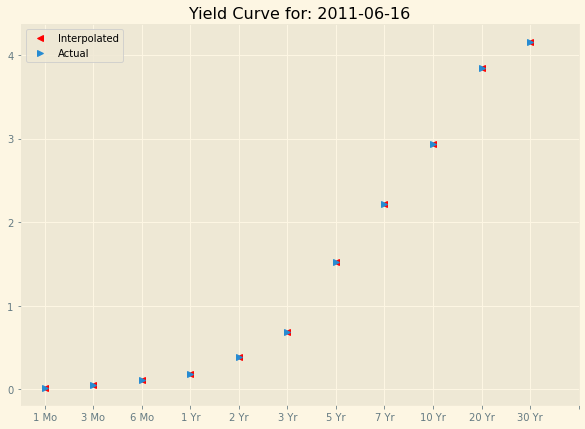

In [ ]:
plt.plot(np.array(main_df.iloc[ridx].drop(["Date"], axis=1)).squeeze(), "r<", label="Interpolated")
plt.plot(np.array(yield_df.iloc[ridx].drop(["Date"], axis=1)).squeeze(), ">", label="Actual")
plt.xticks(list(range(12)), list(main_df.columns)[1:])
plt.title("Yield Curve for: {}".format(list(main_df.iloc[ridx]["Date"])[0].date()))
plt.legend()
plt.show()

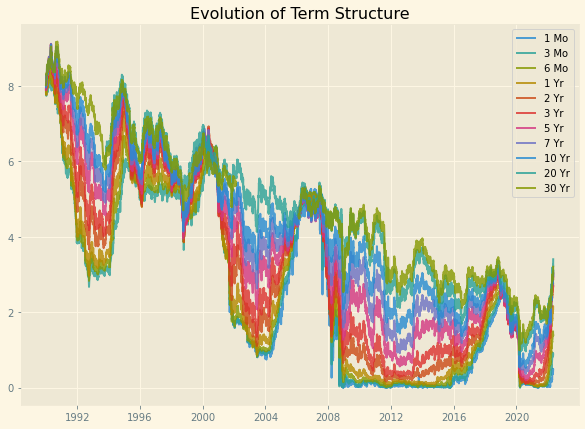

In [ ]:
# plt.rcParams["figure.figsize"] = (20, 10)
for c in list(yield_df.columns)[1:]:
  plt.plot(list(yield_df["Date"]), yield_df[c], "-", alpha=0.8, label=c)
plt.legend()
plt.title("Evolution of Term Structure")
plt.show()

Transforming the data for traning using a Minmax Scaler which assigns a value of 1 to the maximum value and 0 to the minimum.

In [ ]:
scaler = MinMaxScaler()
main_df.iloc[:, 1:] = scaler.fit_transform(main_df.iloc[:, 1:])

In [ ]:
main_df.head()

,Date,1 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
8094,1990-01-02,0.222412,0.947942,0.929162,0.903488,0.868304,0.865705,0.861953,0.869863,0.865811,0.472035,0.855922
8093,1990-01-03,0.222412,0.955206,0.935065,0.908140,0.876116,0.872364,0.867565,0.876712,0.871645,0.472035,0.860806
8092,1990-01-04,0.222412,0.949153,0.930342,0.904651,0.873884,0.869034,0.866442,0.874429,0.870478,0.472035,0.860806
8091,1990-01-05,0.222412,0.943099,0.924439,0.901163,0.871652,0.870144,0.867565,0.875571,0.871645,0.472035,0.863248
8090,1990-01-08,0.222412,0.943099,0.927981,0.903488,0.871652,0.871254,0.867565,0.877854,0.875146,0.472035,0.866911


In [ ]:
look_back = 30
look_ahead = 10

In [ ]:
X_data = []
y_data = []

for i in range(look_back, len(main_df)):
  if i + look_ahead < len(main_df):
    _x, _y = main_df.iloc[i-look_back: i], main_df.iloc[i: i + look_ahead]
    _x, _y = np.array(_x.drop(["Date"], axis=1)), np.array(_y.drop(["Date"], axis=1))
    X_data.append(_x), y_data.append(_y)


In [ ]:
X_tensor = torch.from_numpy(np.array(X_data)).float()
y_tensor = torch.from_numpy(np.array(y_data)).float()

In [ ]:
dataset = TensorDataset(X_tensor, y_tensor)
dl = y_tensor.shape[0]
batch_size = 32

train, valid, test = random_split(dataset, [int(0.75*dl), int(0.15*dl), dl - int(0.75*dl) - int(0.15*dl)])
train_dl = DataLoader(train, shuffle=True, batch_size=batch_size, drop_last=True)
valid_dl = DataLoader(valid, shuffle=True, batch_size=batch_size, drop_last=True)
test_dl = DataLoader(test, shuffle=False, batch_size=batch_size, drop_last=True)

In [ ]:
class EncoderModel(nn.Module):
  def __init__(self, input_dim, batch_size, hidden_dim, n_layers):
    super(EncoderModel, self).__init__()
    self.input_dim = input_dim
    self.n_layers = n_layers
    self.hidden_dim = hidden_dim
    self.batch_size = batch_size

    self.lstm = nn.LSTM(input_size=self.input_dim, hidden_size=self.hidden_dim, 
                        batch_first=True, num_layers=self.n_layers)
    
  def forward(self, input_seq, hidden):
    output, hidden = self.lstm(input_seq, hidden)
    return output, hidden

In [ ]:
class AttnEncoderModel(nn.Module):
  def __init__(self, input_dim, batch_size, hidden_dim, n_layers, input_seq=look_back, output_seq=look_ahead):
    super(AttnEncoderModel, self).__init__()
    self.input_dim = input_dim
    self.n_layers = n_layers
    self.hidden_dim = hidden_dim
    self.batch_size = batch_size

    self.input_seq = input_seq
    self.output_seq = output_seq

    self.lstm = nn.LSTM(input_size=self.input_dim, hidden_size=self.hidden_dim, 
                        batch_first=True, num_layers=self.n_layers, dropout=0.2)
    
    self.attn = nn.Linear(self.hidden_dim, 1)
    
  def forward(self, input_seq, hidden):
    output, hidden = self.lstm(input_seq, hidden)
    o1 = self.attn(output).squeeze(-1)
    weights = nn.Softmax(dim=1)(o1)
    weights = weights.repeat(1, 1, self.hidden_dim).view(self.batch_size, self.hidden_dim, self.input_seq)
    attn_mul = weights.transpose(2, 1) * output
    attn_mul = attn_mul.sum(dim=1)
    output = attn_mul.repeat(1, self.output_seq).reshape(-1, self.output_seq, self.hidden_dim)
    return output, hidden

In [ ]:
class DecoderModel(nn.Module):
  def __init__(self, input_dim, batch_size, hidden_dim, n_layers):
    super(DecoderModel, self).__init__()
    self.input_dim = input_dim
    self.n_layers = n_layers
    self.hidden_dim = hidden_dim
    self.batch_size = batch_size
    
    self.lstm = nn.LSTM(input_size=self.input_dim, hidden_size=self.hidden_dim, 
                        batch_first=True, num_layers=self.n_layers, dropout=0.2)
    
  def forward(self, enco, hidden):
    output, hidden = self.lstm(enco, hidden)
    return output, hidden

In [ ]:
class EncDecModel(nn.Module):
  def __init__(self, encoder, decoder, output_seq, output_dim):
    super(EncDecModel, self).__init__()
    self.encoder = encoder
    self.decoder = decoder

    self.output_dim = output_dim
    self.output_seq = output_seq

  def forward(self, input_seq, hidden):
    out1, hidden = self.encoder(input_seq, hidden)
    out1 = out1[:, -self.output_seq:, :]
    out1 = nn.ReLU()(out1)
    out2, hidden = self.decoder(out1, hidden)
    out2 = out2[:, :, -self.output_dim:]
    # out2 = nn.ReLU()(out2)
    return out2, hidden

In [ ]:
input_dim = 11
input_seq = look_back

output_seq = look_ahead
output_dim = input_dim

enc_hidden = 300
dec_hidden = enc_hidden

n_layers = 4

# enc_model = EncoderModel(input_dim=input_dim, hidden_dim=enc_hidden, 
#                         n_layers=n_layers, batch_size=batch_size)

enc_model = AttnEncoderModel(input_dim=input_dim, hidden_dim=enc_hidden, 
                        n_layers=n_layers, batch_size=batch_size, 
                        input_seq=input_seq, output_seq=output_seq)

dec_model = DecoderModel(input_dim=enc_hidden, hidden_dim=dec_hidden,
                        n_layers=n_layers, batch_size=batch_size)

model = EncDecModel(encoder=enc_model, decoder=dec_model, 
                            output_seq=output_seq, output_dim=output_dim)

In [ ]:
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.HuberLoss()
n_epochs = 150

In [ ]:
patience=3
train_losses = []
valid_losses = []

for epoch in range(n_epochs):
  # if patience == 0:
  #     print("Early Stopping the training.\nEpoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}").format(epoch, train_loss, valid_loss)
  #     break

  train_loss = 0.0
  valid_loss = 0.0  
  
  hidden = (torch.zeros(n_layers, batch_size, enc_hidden).requires_grad_().cuda(),
            torch.zeros(n_layers, batch_size, enc_hidden).requires_grad_().cuda())

  model.train()
  for xt, yt in train_dl:
    xt, yt = xt.cuda(), yt.cuda()

    optimizer.zero_grad()
    hidden = tuple([each.data for each in hidden])
    out, hidden = model(xt, hidden)
    loss = criterion(out, yt)
    loss.backward()
    optimizer.step()
    train_loss += loss.item() * xt.size(0)
  
  hidden = (torch.zeros(n_layers, batch_size, enc_hidden).cuda(),
            torch.zeros(n_layers, batch_size, enc_hidden).cuda())

  model.eval()
  for xv, yv in valid_dl:
    xv, yv = xv.cuda(), yv.cuda()
    with torch.no_grad():
      outv, _ = model(xv, hidden)
      lossv = criterion(outv, yv)
      valid_loss += lossv.item() * xv.size(0)
  
  train_loss = train_loss/len(train_dl.sampler)
  valid_loss = valid_loss/len(valid_dl.sampler)

  if epoch%5 == 0:
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
  
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  if epoch > 5 and valid_loss > valid_losses[-5]:
    patience -= 1


Epoch: 0 	Training Loss: 0.082656 	Validation Loss: 0.025067
Epoch: 5 	Training Loss: 0.004075 	Validation Loss: 0.003503
Epoch: 10 	Training Loss: 0.003214 	Validation Loss: 0.002822
Epoch: 15 	Training Loss: 0.001897 	Validation Loss: 0.001629
Epoch: 20 	Training Loss: 0.001070 	Validation Loss: 0.000865
Epoch: 25 	Training Loss: 0.000753 	Validation Loss: 0.000572
Epoch: 30 	Training Loss: 0.000606 	Validation Loss: 0.000526
Epoch: 35 	Training Loss: 0.000529 	Validation Loss: 0.000479
Epoch: 40 	Training Loss: 0.000477 	Validation Loss: 0.000392
Epoch: 45 	Training Loss: 0.000429 	Validation Loss: 0.000390
Epoch: 50 	Training Loss: 0.000400 	Validation Loss: 0.000339
Epoch: 55 	Training Loss: 0.000377 	Validation Loss: 0.000320
Epoch: 60 	Training Loss: 0.000358 	Validation Loss: 0.000301
Epoch: 65 	Training Loss: 0.000334 	Validation Loss: 0.000291
Epoch: 70 	Training Loss: 0.000325 	Validation Loss: 0.000277
Epoch: 75 	Training Loss: 0.000310 	Validation Loss: 0.000272
Epoch: 80 

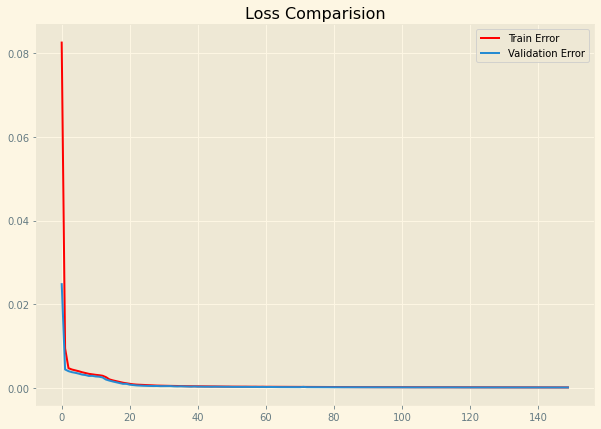

In [ ]:
plt.figure()
plt.plot(train_losses, "r", label="Train Error")
plt.plot(valid_losses, label="Validation Error")
plt.legend()
plt.title("Loss Comparision")
plt.show()

In [ ]:
outs = []
truey = []

hidden = (torch.zeros(n_layers, batch_size, enc_hidden).requires_grad_().cuda(),
            torch.zeros(n_layers, batch_size, enc_hidden).requires_grad_().cuda())

model.eval()
with torch.no_grad():
  for xte, yte in test_dl:
    xte, yte = xte.cuda(), yte.cuda()
    outte, _ = model(xte, hidden)
    outs.append(outte)
    truey.append(yte)

In [ ]:
otte = torch.concat(outs)
trye = torch.concat(truey)

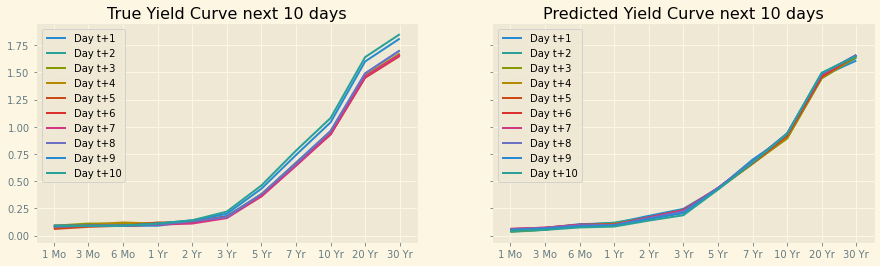

<Figure size 500x350 with 0 Axes>

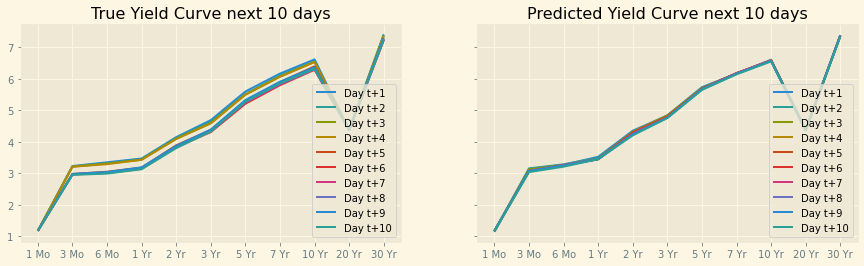

<Figure size 500x350 with 0 Axes>

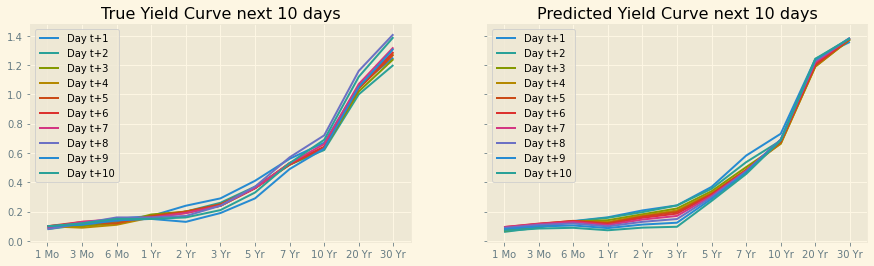

<Figure size 500x350 with 0 Axes>

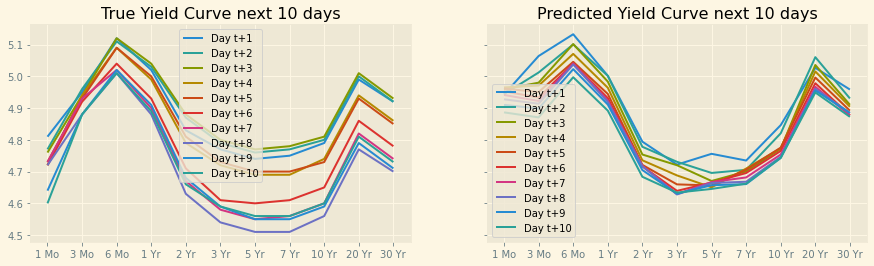

<Figure size 500x350 with 0 Axes>

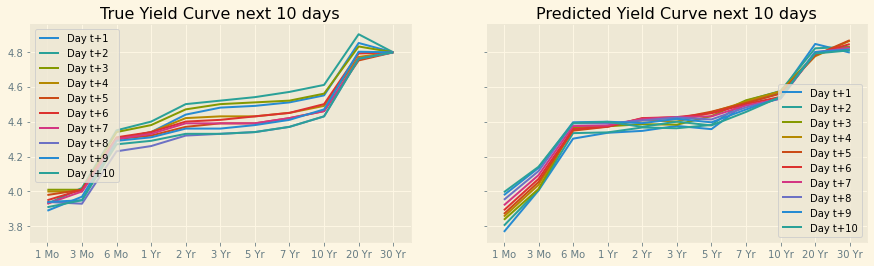

<Figure size 500x350 with 0 Axes>

In [ ]:
for _ in range(5):
  random_idx = np.random.randint(0, len(otte), 1)[0]
  fig, ax = plt.subplots(1, 2, figsize=(15, 4), sharey=True)
  plt.figure(dpi=50)
  plt.setp(ax, xticks=list(range(12)),xticklabels = list(main_df.columns)[1:])
  for i in range(look_ahead):
    r = scaler.inverse_transform(otte[random_idx, i, :].cpu().numpy().reshape(1, -1)).squeeze()
    ax[1].plot(r, "-",label=f"Day t+{i+1}")
  ax[1].legend()
  ax[1].set_title(f"Predicted Yield Curve next {look_ahead} days")
  # print("\n")

  for i in range(look_ahead):
    r = scaler.inverse_transform(trye[random_idx, i, :].cpu().numpy().reshape(1, -1)).squeeze()
    ax[0].plot(r, "-",label=f"Day t+{i+1}")
  ax[0].legend()
  ax[0].set_title(f"True Yield Curve next {look_ahead} days")
  plt.show()
  print("\n")

In [ ]:
y_preds = torch.from_numpy(scaler.inverse_transform(otte.view(-1, 11).cpu().numpy())).float().view(-1, look_ahead, 11)
y_trues = torch.from_numpy(scaler.inverse_transform(trye.view(-1, 11).cpu().numpy())).float().view(-1, look_ahead, 11)
# y_preds = scaler.inverse_transform(otte.view(-1, 11).cpu().numpy()).reshape(-1, look_ahead, 11)
# y_trues = scaler.inverse_transform(trye.view(-1, 11).cpu().numpy()).reshape(-1, look_ahead, 11)

print("\nAverage Absoulte Error for Day")
for i in range(look_ahead):
  l = nn.L1Loss()(y_preds[:, i, :], y_trues[:, i, :]).item()
  # l = np.abs(y_trues[:, i, :] - y_preds[:, i, :])/(y_trues[:, i, :])
  # l = np.round(l.reshape(-1), 5).mean(dtype=np.float64)
  # l = l.mean(dtype=np.float64)
  print(f"Day t+{i+1} :", l)


Average Absoulte Error for Day
Day t+1 : 0.10904865711927414
Day t+2 : 0.10739955306053162
Day t+3 : 0.10417681187391281
Day t+4 : 0.10579680651426315
Day t+5 : 0.11009131371974945
Day t+6 : 0.11369017511606216
Day t+7 : 0.11718260496854782
Day t+8 : 0.12045508623123169
Day t+9 : 0.12525217235088348
Day t+10 : 0.13193851709365845


In [ ]:
print("Average Absoulte Error for Term:")
for i in range(11):
  l = nn.L1Loss()(y_preds[:, :, i], y_trues[:, :, i]).item()
  print(list(main_df.columns)[1:][i], ":",l)

Average Absoulte Error for Term:
1 Mo : 0.07814343273639679
3 Mo : 0.10004159808158875
6 Mo : 0.08613745123147964
1 Yr : 0.09294963628053665
2 Yr : 0.11930534243583679
3 Yr : 0.1346825212240219
5 Yr : 0.1417965143918991
7 Yr : 0.13426415622234344
10 Yr : 0.11901282519102097
20 Yr : 0.11569088697433472
30 Yr : 0.1375105381011963
